### Нашей целью будет предсказать индивидуальные медицинские расходы граждан США, 
### оплачиваемые медицинской страховкой.

In [32]:
# для автозагрузки изменений в модулях без необходимости перезагрузки kelner
%load_ext autoreload
%autoreload 2

# необходимо для корректного импорта своих модулей в JupyterLab
import sys
current_dir = sys.path[0]
project_dir = 'SF_DS_Pro'
last_position = current_dir.find(project_dir) + len(project_dir)
project_path = current_dir[:last_position]
sys.path.append(project_path)

import Handlers as hd

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [33]:
import numpy as np # для матричных вычислений
import pandas as pd # для анализа и предобработки данных
import matplotlib.pyplot as plt # для визуализации
import seaborn as sns # для визуализации

from sklearn import linear_model # линейные модели
from sklearn import metrics # метрики
from sklearn import preprocessing # предобработка
from sklearn.model_selection import train_test_split # сплитование выборки
%matplotlib inline
plt.style.use('seaborn')

**Знакомство с данными**

Набор данных вы можете скачать по [ссылке](https://lms.skillfactory.ru/assets/courseware/v1/12aeb6a8af2d5cdf500e55d3ccbb9f8e/asset-v1:SkillFactory+DSPR-2.0+14JULY2021+type@asset+block/insurance.zip).

In [34]:
load_data = pd.read_csv('data\insurance.zip')

In [35]:
data = load_data.copy()
data

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830
1334,18,female,31.920,0,no,northeast,2205.98080
1335,18,female,36.850,0,no,southeast,1629.83350
1336,21,female,25.800,0,no,southwest,2007.94500


In [36]:
TARGET_FEATURE = 'charges'

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [38]:
data.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [39]:
data.dtypes

age           int64
sex          object
bmi         float64
children      int64
smoker       object
region       object
charges     float64
dtype: object

In [40]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


Целевой признак нужно конвертировать в целый. Точность тут излишняя.

In [41]:
# data[TARGET_FEATURE] = data[TARGET_FEATURE].round().astype('int')

In [42]:
data.describe(include='object')

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


In [43]:
# кодируем бинарные категориальные признаки
data['smoker'] = data['smoker'].apply(lambda x: 0 if x == 'no' else 1)
data['sex'] = data['sex'].apply(lambda x: 0 if x == 'female' else 1)

# оставшиеся категориальные признаки кодируем с помощью OneHotEncoder
# нужно проверить результаты с drop_first и без
data = pd.get_dummies(data, drop_first=True)

In [44]:
data

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0
...,...,...,...,...,...,...,...,...,...
1333,50,1,30.970,3,0,10600.54830,1,0,0
1334,18,0,31.920,0,0,2205.98080,0,0,0
1335,18,0,36.850,0,0,1629.83350,0,1,0
1336,21,0,25.800,0,0,2007.94500,0,0,1


In [45]:
features = data.drop(columns=TARGET_FEATURE).columns
X, y = data[features], data[TARGET_FEATURE]

In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Чему равно количество наблюдений в тестовом наборе данных?

In [47]:
X_test.shape[0]

268

In [48]:
# Инициализируем объект класса линейная регрессия
lr = linear_model.LinearRegression()

# Обучаем модель - ищем параметры
lr.fit(X_train, y_train)

# Делаем предсказание для каждой из выборок
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

Чему равен свободный член (intercept) обученной модели? Ответ округлите до сотых.

In [49]:
round(lr.intercept_, 2)

-11931.22

-11931.22

In [50]:
hd.print_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
R^2: 0.742
MAE: 4208.235
MAPE: 42.203

*** TEST ***
R^2: 0.784
MAE: 4181.194
MAPE: 46.888


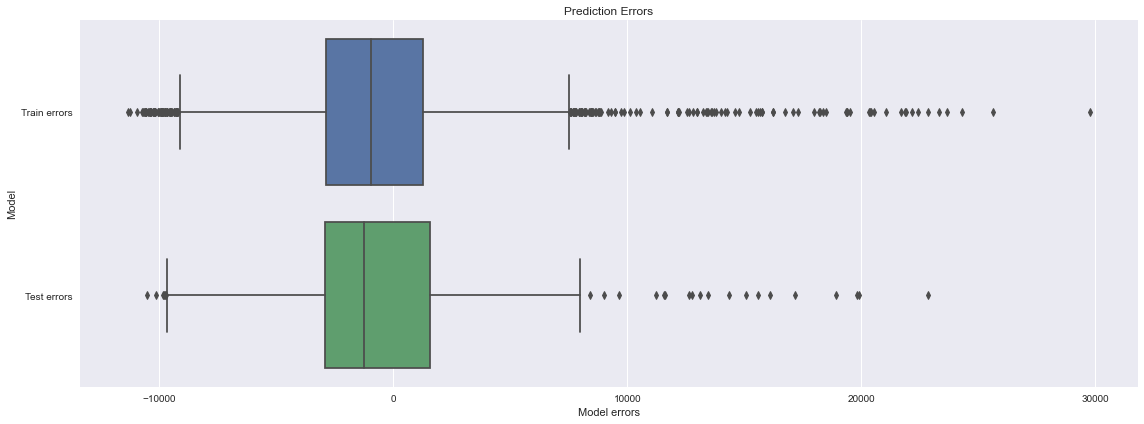

In [51]:
hd.plot_errors_boxplot(y_train, y_train_pred, y_test, y_test_pred)

In [52]:
# Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()

# Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)

# Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создаем объект для генерации полиномиальных признаков степени 2
poly = preprocessing.PolynomialFeatures(degree=2, include_bias=False)

# Вычисляем параметры генерации - результирующее количество признак
poly.fit(X_train_scaled)

# Производим преобразование для каждой из выборок
X_train_scaled_poly = poly.transform(X_train_scaled)
X_test_scaled_poly = poly.transform(X_test_scaled)

print('Train shape: {}'.format(X_train_scaled_poly.shape))
print('Test shape: {}'.format(X_test_scaled_poly.shape))

Train shape: (1070, 44)
Test shape: (268, 44)


In [53]:
lr_poly = linear_model.LinearRegression()
lr_poly.fit(X_train_scaled_poly, y_train)

y_train_pred = lr_poly.predict(X_train_scaled_poly)
y_test_pred = lr_poly.predict(X_test_scaled_poly)

hd.print_regression_metrics(y_train, y_train_pred, y_test, y_test_pred)

*** TRAIN ***
R^2: 0.842
MAE: 2904.961
MAPE: 29.630

*** TEST ***
R^2: 0.866
MAE: 2741.382
MAPE: 30.370


In [54]:
lr_poly.coef_

array([ 2.00132815e+03,  1.43778565e+17,  9.76998805e+03,  7.18023828e+03,
       -2.98881042e+16, -1.99727279e+17, -2.72197739e+16,  1.20503415e+16,
        8.37578853e+03,  7.38933803e+02,  1.07384009e+03, -1.51735211e+03,
        1.45857279e+02,  1.19846237e+03,  2.38892367e+03,  2.80041325e+03,
       -1.43778565e+17,  6.66014426e+02, -1.23889703e+03,  2.77850301e+02,
        1.21252225e+03,  1.51143513e+03,  6.93057285e+02, -9.87790890e+03,
        1.03631698e+03,  5.48743286e+04, -9.09517944e+02, -4.30284381e+03,
       -3.55364351e+03, -2.09026985e+03, -2.12135078e+03,  5.04036930e+01,
       -2.03870168e+03, -3.07550000e+03,  2.98881042e+16, -5.89750000e+02,
       -9.60468750e+02,  1.28000000e+03,  1.99727279e+17,  0.00000000e+00,
        0.00000000e+00,  2.72197739e+16,  0.00000000e+00, -1.20503415e+16])

Значения коэффициентов очень высокие, модель неустойчива, необходима регуляризация.

Постройте линейную регрессию с L1-регуляризацией (Lasso) на полиномиальных признаках. 
В качестве параметра alpha используйте значение по умолчанию, параметр max_iter установите в значение 2000.

In [55]:
# Создаём объект класса линейной регрессии с L1-регуляризацией
lasso_lr_poly = linear_model.Lasso(max_iter=2000)

# Обучаем модель 
lasso_lr_poly.fit(X_train_scaled_poly, y_train)

# Делаем предсказание для тренировочной выборки
y_train_predict_poly = lasso_lr_poly.predict(X_train_scaled_poly)

# Делаем предсказание для тестовой выборки
y_test_predict_poly = lasso_lr_poly.predict(X_test_scaled_poly)

hd.print_regression_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

*** TRAIN ***
R^2: 0.842
MAE: 2890.215
MAPE: 29.427

*** TEST ***
R^2: 0.867
MAE: 2716.605
MAPE: 30.153


In [56]:
lasso_lr_poly.coef_

array([ 2.30651738e+03, -1.21148824e+03,  8.13364614e+03,  6.47839502e+03,
        2.50930018e+03, -9.09709023e+02, -6.03331206e-01, -1.05827906e+03,
        8.30466249e+03,  7.58506179e+02,  8.63014660e+02, -1.21079409e+03,
        1.59567908e+02,  8.57632760e+02,  2.05951184e+03,  2.52113160e+03,
       -4.40241986e+02,  5.28657680e+02, -1.13219735e+03,  2.65432405e+02,
        1.14744807e+03,  1.38015506e+03,  5.40418431e+02, -8.04966541e+03,
        1.22605132e+03,  5.47910391e+04, -2.65975707e+02, -4.27496404e+03,
       -2.99606242e+03, -1.65688961e+03, -2.04578756e+03,  5.20878880e+01,
       -1.84092991e+03, -2.95679367e+03,  8.74441892e+00, -5.43600885e+02,
       -8.17666343e+02,  1.40435186e+03, -5.90120950e+02,  0.00000000e+00,
        0.00000000e+00, -2.16186785e+02,  0.00000000e+00, -1.11055696e+02])

In [57]:
# Создаём объект класса линейной регрессии с L2-регуляризацией
ridge_lr_poly = linear_model.Ridge()

# Обучаем модель 
ridge_lr_poly.fit(X_train_scaled_poly, y_train)

# Делаем предсказание для тренировочной выборки
y_train_predict_poly = ridge_lr_poly.predict(X_train_scaled_poly)

# Делаем предсказание для тестовой выборки
y_test_predict_poly = ridge_lr_poly.predict(X_test_scaled_poly)

hd.print_regression_metrics(y_train, y_train_predict_poly, y_test, y_test_predict_poly)

*** TRAIN ***
R^2: 0.838
MAE: 2947.785
MAPE: 29.548

*** TEST ***
R^2: 0.864
MAE: 2853.456
MAPE: 31.515


In [58]:
ridge_lr_poly.coef_

array([ 3085.79559017,  -854.35024215,  5537.212257  ,  4580.20872182,
        2666.66794668,  -707.63443956,  -255.07358409,  -624.63543425,
        7473.71634435,   544.59837351,  1125.07802738,  -610.57026535,
         719.05602955,   672.50741646,  1640.33594151,  2204.62369171,
        -854.35024215,  1017.32633254,  -832.4507841 ,   738.77309917,
        1053.60609612,  1090.90067181,   458.15591254, -3860.01651303,
        3039.33084531, 44709.94735769,  -284.4504508 , -3482.00918085,
       -2587.72742076, -1054.33553983, -2118.3597018 ,   341.70925249,
       -1539.75800814, -2772.82238901,  2666.66794668,  -279.18040735,
         462.51160612,  2182.89722544,  -707.63443956,     0.        ,
           0.        ,  -255.07358409,     0.        ,  -624.63543425])

Вариант регуляризации Lasso L1 лучше, чем Ridge L2 т.к. тут часть признаков обнулилась через коэффициенты 0.